# Assignment 3 : Compare neighborhoods between Manhattan And Toronto

Import required packages

In [2]:
#clear all var
%reset

In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urllib.request
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt
import wget
import json
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium as folium


## create BS object, list and create dictionary
### get postcodes and neighborhood infos for Toronto City

In [4]:
source = urllib.request.urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').read()

#create soup
soup = BeautifulSoup(source)

#create List
list_postalcode = [1,2,3]

#create dictionary called cell having 3 keys PostalCode, Borough, Neighbourhood
cell = {"PostalCode" :"","Borough" :"","Neighbourhood" : ""}

In [5]:
#create table
table_contents=[]
#create soup, get table
table=soup.find('table')
#create dict with 3 keys, extract data and append to table
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

#print(table_contents)
#create dataframe using list table_contents
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
#print(df.shape)
#print(type(df))


In [6]:
import geocoder # import geocoder
import pgeocode #utilize pgecode instead

In [7]:
#this cell utilizes pgeocode to get lats and logs into lists of lats and longs
pgeocode.Nominatim('ca')
geolocator = pgeocode.Nominatim('ca')
postal_codes = df['PostalCode'].tolist()
latitudes = []
longitudes = []
for i, postal_code in enumerate(postal_codes):
    # initialize your variable to None
    #print(f'--Getting Postal Code: {postal_code}')
    g = geolocator.query_postal_code(postal_code)
    
    if not g.empty:
        #print(f'Postal Code {postal_code} has been retrieved. {len(postal_codes) - (i + 1)} codes left')
        latitudes.append(g.latitude)
        longitudes.append(g.longitude)

In [8]:
#this cell inserts the lat and longitudes into the main dataframe
df= pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df1 = pd.DataFrame(latitudes)
df.insert(3,"Latitude",latitudes)
df.insert(4,"Longitude",longitudes)
print(df.head)
neighborhoods = df

#print(neighborhoods)

<bound method NDFrame.head of     PostalCode                Borough  \
0          M3A             North York   
1          M4A             North York   
2          M5A       Downtown Toronto   
3          M6A             North York   
4          M7A           Queen's Park   
..         ...                    ...   
98         M8X              Etobicoke   
99         M4Y       Downtown Toronto   
100        M7Y  East Toronto Business   
101        M8Y              Etobicoke   
102        M8Z              Etobicoke   

                                          Neighborhood  Latitude  Longitude  
0                                            Parkwoods   43.7545   -79.3300  
1                                     Victoria Village   43.7276   -79.3148  
2                            Regent Park, Harbourfront   43.6555   -79.3626  
3                     Lawrence Manor, Lawrence Heights   43.7223   -79.4504  
4                        Ontario Provincial Government   43.6641   -79.3889  
..       

create map of toronto

In [9]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


get the coordinates of Toronto as a city to center map pgeocode 

In [10]:

address = 'Toronto,Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Clustering the neighbourhoods as per previous exercise

Filter boroughs to only ones containing "Toronto"

In [11]:
df_toronto_only = df[df['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_only = df_toronto_only.sort_values('Borough')
df_toronto_only[0:5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
19,M5N,Central Toronto,Roselawn,43.7113,-79.4195
31,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025
29,M4T,Central Toronto,"Moore Park, Summerhill East",43.6899,-79.3853
26,M4S,Central Toronto,Davisville,43.7020,-79.3853
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.6736,-79.4035


## Repeat same for manhattan
## import all manhattan neighborhoods


In [12]:
#impot wget
import wget
import json

In [13]:
wget.download("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json")

'newyork_data (5).json'

In [14]:
#load data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

## define vvariable with features and transform to pandas DF

In [15]:
#define variable from json, get features only. create empty dataframe

neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_NY = pd.DataFrame(columns=column_names)

#loop and fill dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_NY = neighborhoods_NY.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [16]:
# simplify data,slice and get only in Manhattan
manhattan_data = neighborhoods_NY[neighborhoods_NY['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [17]:
#Use geopy to get lat and long,get coord manhattan
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


## Use Foursquare API to get info on venues
-define Foursquare credentials and version (for submission, id and secret removed)

In [111]:
CLIENT_ID = ' #'client id' #'client id' # your Foursquare ID
CLIENT_SECRET = '# your Foursquare Secret' # your Foursquare Secret
ACCESS_TOKEN = '# your FourSquare Access Token' # your FourSquare Access Token
#CLIENT_ID = '# your Foursquare Secret' #'client id' # your Foursquare ID
#CLIENT_SECRET = '# your Foursquare Secret' # your Foursquare Secret
#ACCESS_TOKEN = '# your FourSquare Access Token' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



SyntaxError: invalid syntax (<ipython-input-111-157a0236ddc8>, line 1)

Explore first neighbor hood in df_toronto_only

In [19]:
neighborhood_name = df_toronto_only.loc[0, 'Neighborhood']
print(f"The first neighborhood's name is '{neighborhood_name}'.")

The first neighborhood's name is 'Regent Park, Harbourfront'.


Get the neighborhoods lat and long values

In [20]:
neighborhood_latitude = df_toronto_only.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto_only.loc[0, 'Longitude'] # neighborhood longitude value
 
print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6555, -79.3626.


get top 100 venues nearby that neighborhood

-send GET request and examine result
- get category type

clean json and sturcture to pd dataframe

Function to loop same process for all neighborhoods in Toronto

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
results

NameError: name 'results' is not defined

In [25]:
#run above function and fill into dataframe called toronto_venues

toronto_venues = getNearbyVenues(names=df_toronto_only['Neighborhood'],
                                   latitudes=df_toronto_only['Latitude'],
                                   longitudes=df_toronto_only['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()

Roselawn
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Moore Park, Summerhill East
Davisville
The Annex, North Midtown, Yorkville
North Toronto West
Forest Hill North & West
Davisville North
Lawrence Park
First Canadian Place, Underground city
St. James Town, Cabbagetown
Rosedale
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Kensington Market, Chinatown, Grange Park
University of Toronto, Harbord
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
Toronto Dominion Centre, Design Exchange
St. James Town
Harbourfront East, Union Station, Toronto Islands
Berczy Park
Commerce Court, Victoria Hotel
Central Bay Street
Richmond, Adelaide, King
Christie
Enclave of M5E
Studio District
India Bazaar, The Beaches West
The Danforth West, Riverdale
The Beaches
Enclave of M4L
The Danforth  East
Parkdale, Roncesvalles
Little Portugal, Trinity
High Park, The Junction South
Brockton, Parkdale Village, Ex

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roselawn,43.7113,-79.4195,BAGEL TIME MONTREAL STYLE,43.709067,-79.415858,Fast Food Restaurant
1,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,The Market By Longo’s,43.686711,-79.399536,Supermarket
2,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,LCBO,43.686991,-79.399238,Liquor Store
3,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,Tim Hortons,43.687682,-79.396840,Coffee Shop
4,"Summerhill West, Rathnelly, South Hill, Forest...",43.6861,-79.4025,Starbucks,43.686756,-79.398292,Coffee Shop


In [26]:
print('There are {} uniques categories in Toronto.'.format(len(toronto_venues['Venue Category'].unique())))

There are 219 uniques categories in Toronto.


### Repeat for Manhattan

In [27]:
#run above function and fill into dataframe called manhattan_venues

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
print(manhattan_venues.shape)
manhattan_venues.head()

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
(3269, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
1,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


In [28]:
print('There are {} uniques categories in Manhattan.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 330 uniques categories in Manhattan.


### Combine toronto_venues and manhattan_venues into one compare_venues dataframe

In [29]:
#add column with toronto/manhattan into each dataframe
toronto_venues['city']='Toronto'
manhattan_venues['city']='Manhattan'

frames =[toronto_venues,manhattan_venues]
city_venues = pd.concat(frames)
print(city_venues[0:4])

                                        Neighborhood  Neighborhood Latitude  \
0                                           Roselawn                43.7113   
1  Summerhill West, Rathnelly, South Hill, Forest...                43.6861   
2  Summerhill West, Rathnelly, South Hill, Forest...                43.6861   
3  Summerhill West, Rathnelly, South Hill, Forest...                43.6861   

   Neighborhood Longitude                      Venue  Venue Latitude  \
0                -79.4195  BAGEL TIME MONTREAL STYLE       43.709067   
1                -79.4025      The Market By Longo’s       43.686711   
2                -79.4025                       LCBO       43.686991   
3                -79.4025                Tim Hortons       43.687682   

   Venue Longitude        Venue Category     city  
0       -79.415858  Fast Food Restaurant  Toronto  
1       -79.399536           Supermarket  Toronto  
2       -79.399238          Liquor Store  Toronto  
3       -79.396840           Coffee

## Analysis
-explore number of neighborhoods vs borough vs venues

In [30]:
#import plotly
import plotly.graph_objects as go

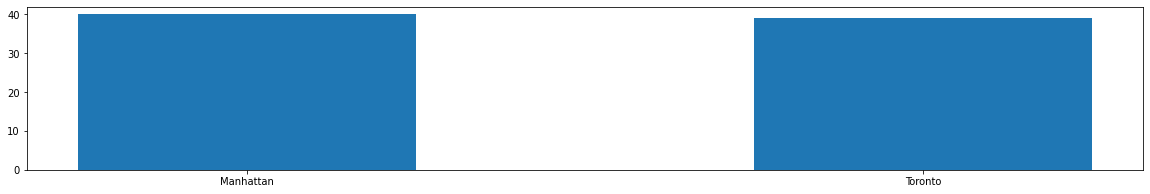

In [31]:
#number of neighborhoods in manhattan data set

df_toronto_only['city']='Toronto'
manhattan_data['city']='Manhattan'

frames2 = [manhattan_data,df_toronto_only]
n_neighborhoods = pd.concat(frames2)

neighborhood_qty = n_neighborhoods.groupby('city').count()
neighborhood_qty = neighborhood_qty.sort_values(by=['Neighborhood'], ascending=False)

plt.figure(figsize=(20,3))
plt.bar(neighborhood_qty.reset_index()['city'],neighborhood_qty.reset_index()['Neighborhood'], width=0.5)
plt.show()


note: similar number of neighborhoods for comparison

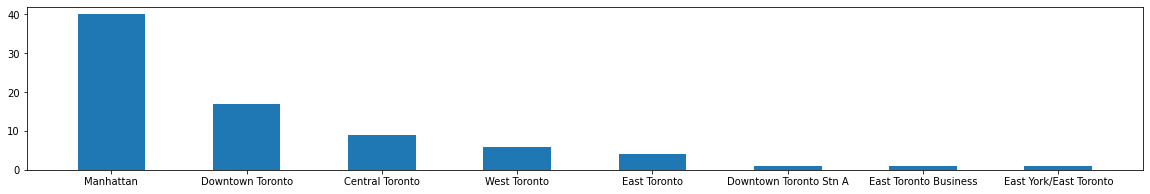

In [32]:
#plot number of neighborhoods in each borough in Toronto
neighborhood_qty = n_neighborhoods.groupby('Borough').count()
neighborhood_qty = neighborhood_qty.sort_values(by=['Neighborhood'], ascending=False)
#neighborhood_qty.reset_index()

plt.figure(figsize=(20,3))
plt.bar(neighborhood_qty.reset_index()['Borough'],neighborhood_qty.reset_index()['Neighborhood'], width=0.5)
plt.show()

only Manhattan Borough (1) for NY, neighborhoods are split to 7 boroughs for Toronto

In [104]:
#check how many venues for each neighborhood
#note limitation on Foursquare venues search roughly 23 venues per neighborhood at times
# current limt to 100 venues per neighborhood
#compare manhattan vs toronto
import plotly.graph_objects as go
venues_qty = city_venues.groupby('Neighborhood').count()
#venues_qty = venues_qty.sort_values(by=['city'], ascending=False)
#venues_qty = n_neighborhoods
venues_qty = venues_qty.merge(n_neighborhoods,on='Neighborhood', how='left')

fig= go.Figure()
fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Neighborhood"),
    yaxis=dict(title_text="Venue Count"),
    width=1500,
    height = 1500,
    margin = dict(
        l=50,
        r=50,
        b= 400,
        t=100,
        pad=5
    )
)

#cities_merged = cities_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

colors = ["#2A66DE", "#FFC32B"]
x1 =  venues_qty['city_y'].tolist()
x2 =  venues_qty['Neighborhood'].tolist()
x = [x1,x2]

y= venues_qty['Venue Latitude'].tolist()


fig.add_bar(x=x, y=y)

#fig.add_bar(x=venues_qty[''])
#fig.update_layout(barmode="relative")


fig.show()

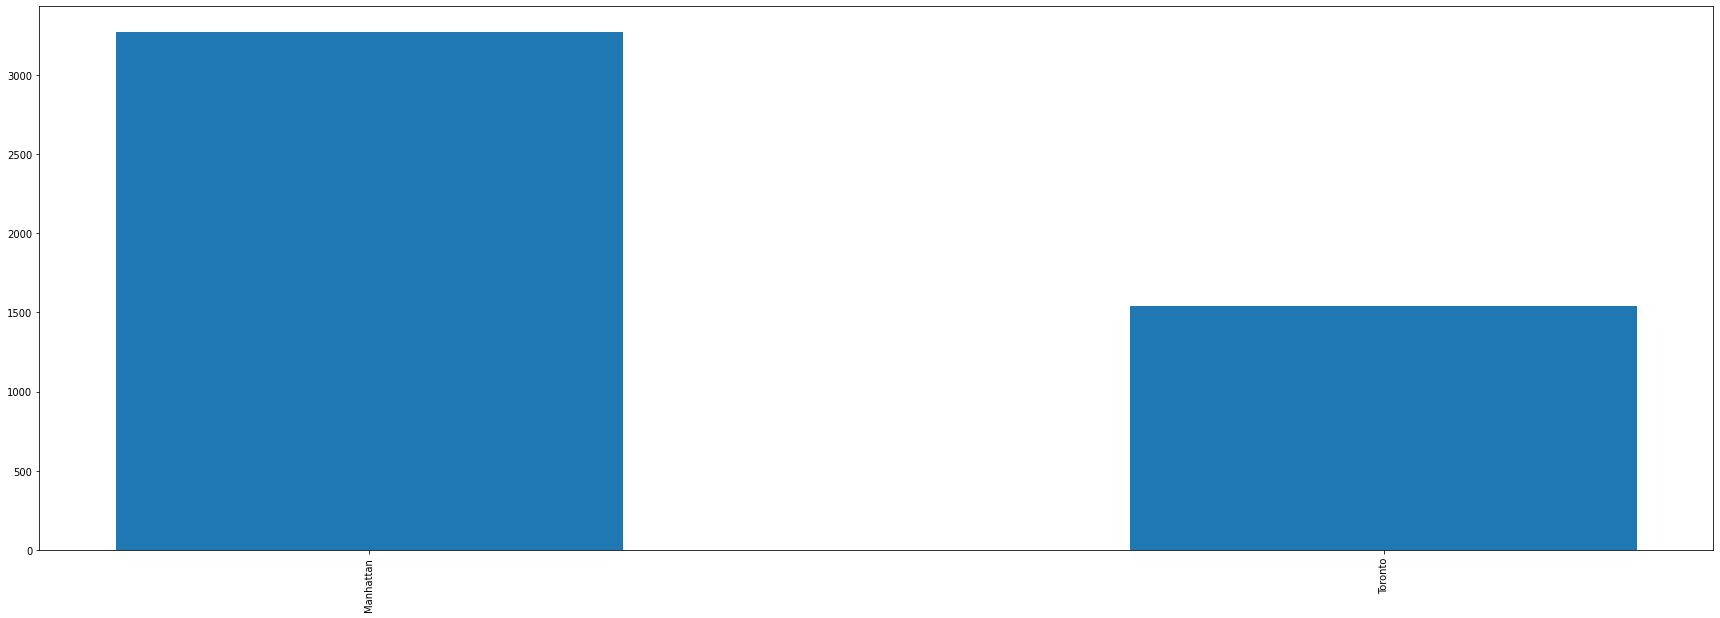

In [34]:
#check venues per cities compared

venues_qty = city_venues.groupby('city').count()
venues_qty = venues_qty.sort_values(by=['Venue'], ascending=False)


plt.figure(figsize=(30,10))
plt.bar(venues_qty.reset_index()['city'],venues_qty.reset_index()['Venue'], width=0.5)
plt.xticks(rotation=90)
plt.show()

much more venues per neighborhood in Manhattan compared to Toronto given same number of neighborhoods. Could be more densely populated

In [35]:

venues_type = city_venues.drop(['Neighborhood Latitude','Neighborhood Longitude','Venue Latitude','Venue Longitude'],axis=1)
#print(city_venues[0:5])
venues_type2 = venues_type.groupby('city').nunique()
print(venues_type2)

           Neighborhood  Venue  Venue Category
city                                          
Manhattan            40   2800             330
Toronto              39    964             219


In [45]:

venues_type_toronto = city_venues[city_venues['city']=='Toronto'].groupby('Venue Category').count()['Venue']
venues_type_manhattan = city_venues[city_venues['city']=='Manhattan'].groupby('Venue Category').count()['Venue']
venues_type = pd.concat([venues_type_toronto,venues_type_manhattan],axis=1)
venues_type = venues_type.reset_index()


#reset header
venues_type.columns = ['Venue Category','Toronto Venues', 'Manhattan Venues']
venues_type = venues_type.set_index(['Venue Category'])
venues_type =  venues_type.sort_values(by=['Manhattan Venues'],ascending=False)

print(venues_type)
venues_type.dtypes

                     Toronto Venues  Manhattan Venues
Venue Category                                       
Coffee Shop                   136.0             133.0
Italian Restaurant             37.0             124.0
Café                           86.0              80.0
Pizza Place                    28.0              79.0
American Restaurant            18.0              76.0
...                             ...               ...
Smoothie Shop                   1.0               NaN
Tanning Salon                   2.0               NaN
Theme Restaurant                1.0               NaN
Tibetan Restaurant              1.0               NaN
Train Station                   2.0               NaN

[367 rows x 2 columns]


Toronto Venues      float64
Manhattan Venues    float64
dtype: object

Graph showing venue quantity by type by cities

In [46]:
#reset dataframe index
venues_type = venues_type.reset_index(col_level=0, col_fill='')


Text(0, 0.5, 'Venue count')

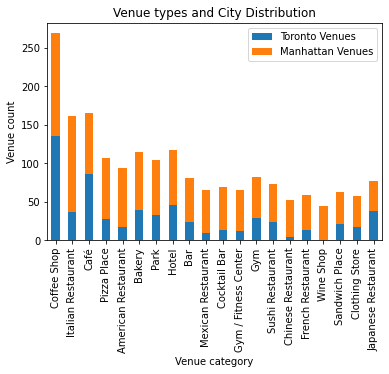

In [47]:
#check how many venues per venue type
#note limitation on Foursquare venues search roughly 23 venues per neighborhood at time

#plot only top 20 venue types

venues_type[0:20].set_index(['Venue Category']).plot(kind="bar",stacked=True)
plt.title("Venue types and City Distribution")
plt.xlabel("Venue category")
plt.ylabel("Venue count")
#plt.figure(figsize=(30,5))



Coffee shops and cafes are popular across both cities. Italian restaurants are popular in Manhattan and Toronto. Hotels and bakeries are also popular.

Graph showing specific only restaurants

In [41]:
#reset dataframe index
venues_type = venues_type.reset_index(col_level=0, col_fill='')


C:\Users\fmazl\anaconda3\envs\pytest\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



<AxesSubplot:title={'center':'Top 20 Manhattan venues'}, xlabel='Venue Category'>

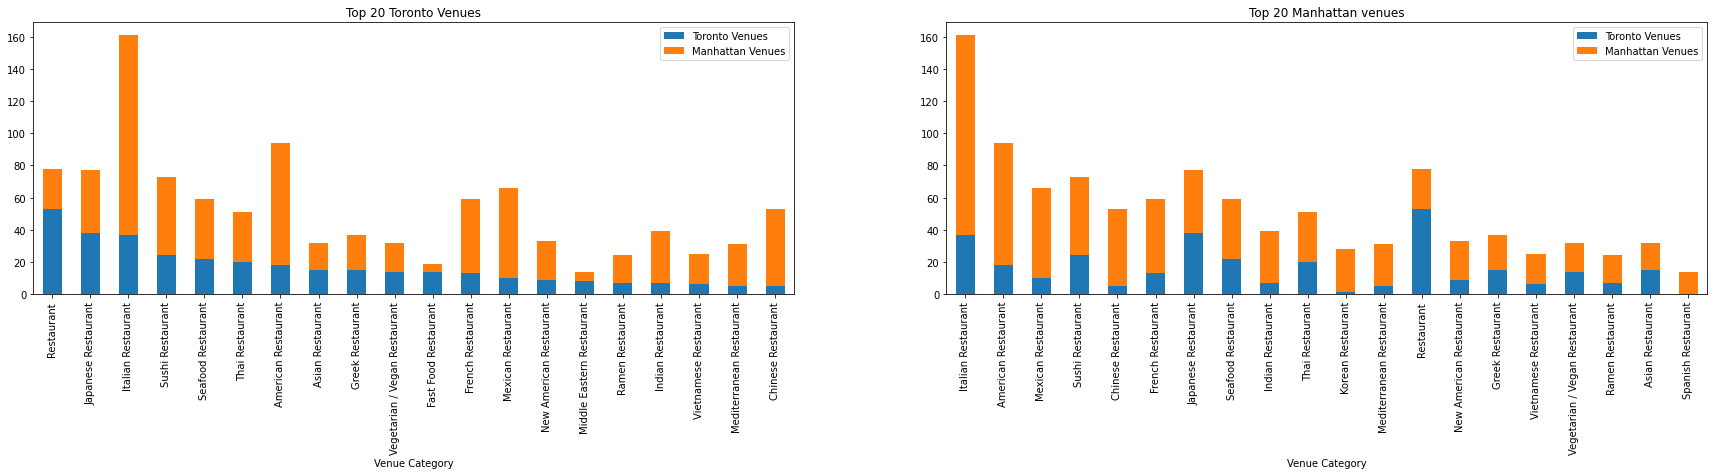

In [48]:
#prep data to show popular restaurants by city
restaurant_qty = venues_type[venues_type['Venue Category'].astype(str).str.contains("Restaurant")]
restaurant_qty = restaurant_qty.set_index(['Venue Category'])
restaurant_qty_toronto = restaurant_qty.sort_values(by=['Toronto Venues'],ascending=False)
restaurant_qty_manhattan = restaurant_qty.sort_values(by=['Manhattan Venues'],ascending=False)

#create subplot figure 
fig, axes = plt.subplots(ncols=2,figsize=(30,5))

#plot first
restaurant_qty_toronto[0:20].plot(title='Top 20 Toronto Venues',ax=axes[0],kind="bar",stacked=True)
restaurant_qty_manhattan[0:20].plot(title='Top 20 Manhattan venues',ax=axes[1],kind="bar",stacked=True)


comparing restaurant types popularity between the two cities
* Italian restaurants are generally popular between both places
* Mexican food is popular in Manhattan but not as much as in Toronto
* asian restaurants (Japense,sushi, chinese,vietnamese etc.) are popular among both cities. However, Chinese restaurants are more easily found in Manhattan

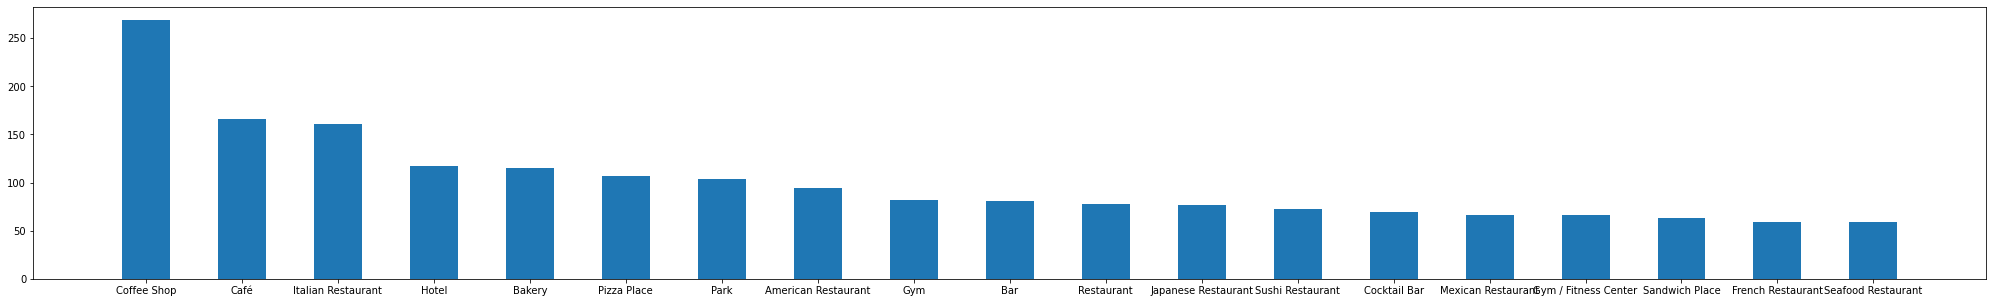

In [49]:
#check how many venues per venue type
#note limitation on Foursquare venues search roughly 23 venues per neighborhood at times



#toronto_venues.sort_values(by=['Neighborhood'])
venues_type2 = city_venues.groupby('city').nunique()
venues_type = city_venues.groupby('Venue Category').count()
venues_type = venues_type.sort_values(by=['Venue'], ascending=False)
#plot only top 20 venue types


plt.figure(figsize=(35,5))
x=venues_type.reset_index()['Venue Category'][0:19]
y=venues_type.reset_index()['Venue'][0:19]
plt.bar(x,y,width=0.5)
plt.show()

In [ ]:
print(venues_type)
print(venues_type2)

                       Neighborhood  Neighborhood Latitude  \
Venue Category                                               
Coffee Shop                     265                    265   
Café                            166                    166   
Italian Restaurant              165                    165   
Bakery                          115                    115   
Hotel                           113                    113   
...                             ...                    ...   
Portuguese Restaurant             1                      1   
College Cafeteria                 1                      1   
College Rec Center                1                      1   
College Theater                   1                      1   
Polish Restaurant                 1                      1   

                       Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                         
Coffee Shop                               265    

### Analyze neighborhood using one hot encoding

In [50]:
# one hot encoding
cities_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['Neighborhood'] = city_venues['Neighborhood'] 
 
# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]
 
cities_onehot.head()

,Yoga Studio,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Group rows by neighborhood and taking mean of frequency of occurrence per category

In [52]:
cities_grouped=cities_onehot.groupby('Neighborhood').mean().reset_index()
cities_grouped.shape

(79, 367)

In [53]:
#print each neighbor hood with top 5 most common venues

num_top_venues = 5
for hood in cities_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cities_grouped[cities_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

    

----Battery Park City----
            venue  freq
0            Park  0.09
1           Hotel  0.05
2  Clothing Store  0.05
3     Coffee Shop  0.05
4             Gym  0.03


----Berczy Park----
          venue  freq
0   Coffee Shop  0.11
1        Bakery  0.05
2         Hotel  0.05
3          Café  0.04
4  Cocktail Bar  0.03


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.08
1             Coffee Shop  0.08
2               Gift Shop  0.05
3  Thrift / Vintage Store  0.05
4          Breakfast Spot  0.05


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0         Coffee Shop  0.07
1  Italian Restaurant  0.07
2                 Bar  0.05
3                Café  0.05
4              Bakery  0.03


----Carnegie Hill----
                  venue  freq
0           Coffee Shop  0.08
1                  Café  0.07
2             Wine Shop  0.04


### place above into pandas dataframe

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Create new dataframe and display top 10 venues per neighborhood

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cities_grouped['Neighborhood']

for ind in np.arange(cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Park,Hotel,Clothing Store,Coffee Shop,Gym,Playground,Memorial Site,Women's Store,Sandwich Place,Bistro
1,Berczy Park,Coffee Shop,Bakery,Hotel,Café,Cocktail Bar,Japanese Restaurant,Beer Bar,Seafood Restaurant,Restaurant,Cheese Shop
2,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Gift Shop,Thrift / Vintage Store,Breakfast Spot,Bakery,Cocktail Bar,Bar,Pet Store,Beach Bar
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Italian Restaurant,Bar,Café,Bakery,Restaurant,Gym / Fitness Center,Park,Grocery Store,Speakeasy
4,Carnegie Hill,Coffee Shop,Café,Wine Shop,Yoga Studio,Gym / Fitness Center,Gym,Pizza Place,French Restaurant,Bookstore,Pub


### Create K-Clusters

find best k for accuracy
- need to split test and training set

In [56]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [57]:
print(cities_grouped)

                                         Neighborhood  Yoga Studio  \
0                                   Battery Park City     0.000000   
1                                         Berczy Park     0.010638   
2        Brockton, Parkdale Village, Exhibition Place     0.000000   
3   CN Tower, King and Spadina, Railway Lands, Har...     0.017241   
4                                       Carnegie Hill     0.032609   
..                                                ...          ...   
74                                    Upper East Side     0.030612   
75                                    Upper West Side     0.000000   
76                                 Washington Heights     0.000000   
77                                       West Village     0.000000   
78                                          Yorkville     0.000000   

    Accessories Store  Acupuncturist  Adult Boutique  Afghan Restaurant  \
0            0.000000            0.0            0.00                0.0   
1        

In [58]:
#drop categorical
cities_grouped_clustering = cities_grouped.drop('Neighborhood', 1)

In [59]:
# elbow method to find optimum kclusters

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(cities_grouped_clustering)
    kmeanModel.fit(cities_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(cities_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / cities_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(cities_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / cities_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

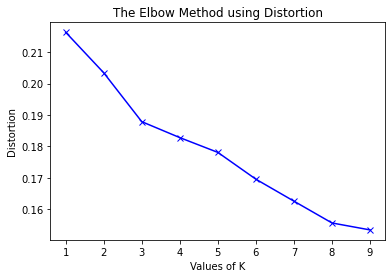

In [60]:
#plot elbow method using distortion

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

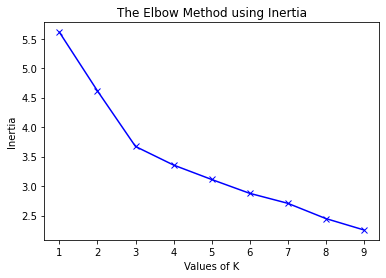

In [61]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

optimum k ~ 3
however choose 5 just for test

In [62]:

# set number of clusters
kclusters = 5


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:30] 


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 4])

In [63]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = n_neighborhoods

# merge cities_grouped with manhattan_data to add latitude/longitude for each neighborhood
cities_merged = cities_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#neighborhoods_venues_sorted
cities_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,city,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,Manhattan,NaN,0,Sandwich Place,Gym,Yoga Studio,Pizza Place,Seafood Restaurant,Tennis Stadium,Coffee Shop,Optical Shop,Supplement Shop,Pharmacy
1,Manhattan,Chinatown,40.715618,-73.994279,Manhattan,NaN,0,Chinese Restaurant,Bakery,Cocktail Bar,Dessert Shop,American Restaurant,Hotpot Restaurant,Optical Shop,Salon / Barbershop,Dumpling Restaurant,Sandwich Place
2,Manhattan,Washington Heights,40.851903,-73.936900,Manhattan,NaN,0,Café,Bakery,Grocery Store,Mobile Phone Shop,Chinese Restaurant,Donut Shop,Pizza Place,Bank,Park,Tapas Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,Manhattan,NaN,0,Mexican Restaurant,Restaurant,Café,Bakery,Lounge,Caribbean Restaurant,Chinese Restaurant,Diner,Park,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,Manhattan,NaN,0,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant,Cocktail Bar,Sushi Restaurant,Bakery,Liquor Store,Caribbean Restaurant


### Visualize clusters
* show top 5 venues for each cluster
examine clusters and find discriminating venue categories that distinguish each cluster

### Cluster 0

In [64]:
cities_merged.loc[cities_merged['Cluster Labels'] ==0, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]


,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,NaN,0,Sandwich Place,Gym,Yoga Studio,Pizza Place,Seafood Restaurant,Tennis Stadium,Coffee Shop,Optical Shop,Supplement Shop,Pharmacy
1,Manhattan,Chinatown,NaN,0,Chinese Restaurant,Bakery,Cocktail Bar,Dessert Shop,American Restaurant,Hotpot Restaurant,Optical Shop,Salon / Barbershop,Dumpling Restaurant,Sandwich Place
2,Manhattan,Washington Heights,NaN,0,Café,Bakery,Grocery Store,Mobile Phone Shop,Chinese Restaurant,Donut Shop,Pizza Place,Bank,Park,Tapas Restaurant
3,Manhattan,Inwood,NaN,0,Mexican Restaurant,Restaurant,Café,Bakery,Lounge,Caribbean Restaurant,Chinese Restaurant,Diner,Park,Deli / Bodega
4,Manhattan,Hamilton Heights,NaN,0,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant,Cocktail Bar,Sushi Restaurant,Bakery,Liquor Store,Caribbean Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,West Toronto,"Parkdale, Roncesvalles",M6R,0,Coffee Shop,Bakery,Sushi Restaurant,Eastern European Restaurant,Thai Restaurant,Gift Shop,Breakfast Spot,Bookstore,American Restaurant,Café
11,West Toronto,"Little Portugal, Trinity",M6J,0,Bar,Vegetarian / Vegan Restaurant,Diner,Cocktail Bar,Coffee Shop,Vietnamese Restaurant,Men's Store,Restaurant,Asian Restaurant,Pizza Place
14,West Toronto,"Brockton, Parkdale Village, Exhibition Place",M6K,0,Café,Coffee Shop,Gift Shop,Thrift / Vintage Store,Breakfast Spot,Bakery,Cocktail Bar,Bar,Pet Store,Beach Bar
28,West Toronto,"Runnymede, Swansea",M6S,0,Café,Pizza Place,Sushi Restaurant,Bank,Falafel Restaurant,Italian Restaurant,Pub,Electronics Store,Coffee Shop,Yoga Studio


In [65]:
cluster0 = cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues0 = (cluster0['1st Most Common Venue'].append(
    cluster0['2nd Most Common Venue']).append(
    cluster0['3rd Most Common Venue']).append(
    cluster0['4th Most Common Venue']).append(
    cluster0['5th Most Common Venue']).append(
    cluster0['6th Most Common Venue']).append(
    cluster0['7th Most Common Venue']).append(
    cluster0['8th Most Common Venue']).append(
    cluster0['9th Most Common Venue']).append(
    cluster0['10th Most Common Venue']))

print(venues0.value_counts().head(10))

Coffee Shop             57
Café                    37
Italian Restaurant      28
Park                    28
Bakery                  25
Pizza Place             22
Hotel                   21
Gym                     17
Bar                     16
Gym / Fitness Center    16
dtype: int64


## Cluster 1

In [66]:
cities_merged.loc[cities_merged['Cluster Labels'] ==1, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,West Toronto,"High Park, The Junction South",M6P,1,Intersection,Park,Music School,Music Store,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors,Organic Grocery


In [67]:
cluster1 = cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Music Store                      1
Paper / Office Supplies Store    1
Outdoor Sculpture                1
Other Great Outdoors             1
Outdoors & Recreation            1
Organic Grocery                  1
Intersection                     1
Music School                     1
Park                             1
Paella Restaurant                1
dtype: int64


### Cluster 2

In [68]:
cities_merged.loc[cities_merged['Cluster Labels'] ==2, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,Roselawn,M5N,2,Fast Food Restaurant,Yoga Studio,Office,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors,Organic Grocery,Optical Shop


In [69]:
cluster2 = cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Other Great Outdoors             1
Paper / Office Supplies Store    1
Yoga Studio                      1
Outdoor Sculpture                1
Outdoors & Recreation            1
Fast Food Restaurant             1
Office                           1
Organic Grocery                  1
Paella Restaurant                1
Optical Shop                     1
dtype: int64


## Cluster 3

In [70]:
cities_merged.loc[cities_merged['Cluster Labels'] ==3, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,Lawrence Park,M4N,3,Park,Photography Studio,Office,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors,Organic Grocery,Optical Shop


In [71]:
cluster3 = cities_merged.loc[cities_merged['Cluster Labels'] == 3, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Other Great Outdoors             1
Paper / Office Supplies Store    1
Outdoor Sculpture                1
Photography Studio               1
Outdoors & Recreation            1
Organic Grocery                  1
Office                           1
Park                             1
Paella Restaurant                1
Optical Shop                     1
dtype: int64


## Cluster 4

In [72]:
cities_merged.loc[cities_merged['Cluster Labels'] ==4, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,"Moore Park, Summerhill East",M4T,4,Park,Gym,Thai Restaurant,Grocery Store,Office,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors,Organic Grocery,Optical Shop
23,Central Toronto,North Toronto West,M4R,4,Gym Pool,Playground,Park,Café,Office,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors
21,Central Toronto,Forest Hill North & West,M5P,4,Park,Photography Studio,Trail,Business Service,Liquor Store,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors
33,Downtown Toronto,Rosedale,M4W,4,Grocery Store,Playground,Candy Store,Park,Yoga Studio,Opera House,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors
10,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",M5J,4,Café,Music Venue,Park,Harbor / Marina,Nail Salon,Optical Shop,Music Store,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation
6,Downtown Toronto,Christie,M6G,4,Grocery Store,Café,Candy Store,Playground,Coffee Shop,Baby Store,Athletics & Sports,Park,Noodle House,North Indian Restaurant
9,East York/East Toronto,The Danforth East,M4J,4,Park,Convenience Store,Massage Studio,Yoga Studio,Opera House,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors


In [73]:
cluster4 = cities_merged.loc[cities_merged['Cluster Labels'] == 4, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Park                             7
Outdoors & Recreation            6
Outdoor Sculpture                5
Other Great Outdoors             5
Paella Restaurant                5
Paper / Office Supplies Store    4
Café                             3
Grocery Store                    3
Playground                       3
Office                           2
dtype: int64


### Cluster 5

In [74]:
cities_merged.loc[cities_merged['Cluster Labels'] ==5, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [ ]:
cluster5 = cities_merged.loc[cities_merged['Cluster Labels'] == 5, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Series([], dtype: int64)


### Cluster 6

In [ ]:
cities_merged.loc[cities_merged['Cluster Labels'] ==6, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,The Danforth East,M4J,6.0,Convenience Store,Yoga Studio,Office,Paper / Office Supplies Store,Paella Restaurant,Outdoors & Recreation,Outdoor Sculpture,Other Great Outdoors,Organic Grocery,Optical Shop


In [ ]:
cluster6 = cities_merged.loc[cities_merged['Cluster Labels'] == 6, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Yoga Studio                      1
Office                           1
Outdoor Sculpture                1
Paella Restaurant                1
Outdoors & Recreation            1
Optical Shop                     1
Convenience Store                1
Other Great Outdoors             1
Paper / Office Supplies Store    1
Organic Grocery                  1
dtype: int64


### Cluster 7

In [ ]:
cities_merged.loc[cities_merged['Cluster Labels'] ==7, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]

,Borough,Neighborhood,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [ ]:
cluster7 = cities_merged.loc[cities_merged['Cluster Labels'] == 7, cities_merged.columns[[0] +[1] + list(range(5,cities_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Series([], dtype: int64)


### Discussion
Visualize top 5 common venues

C:\Users\fmazl\anaconda3\envs\pytest\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning:


The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.



IndexError: list index out of range

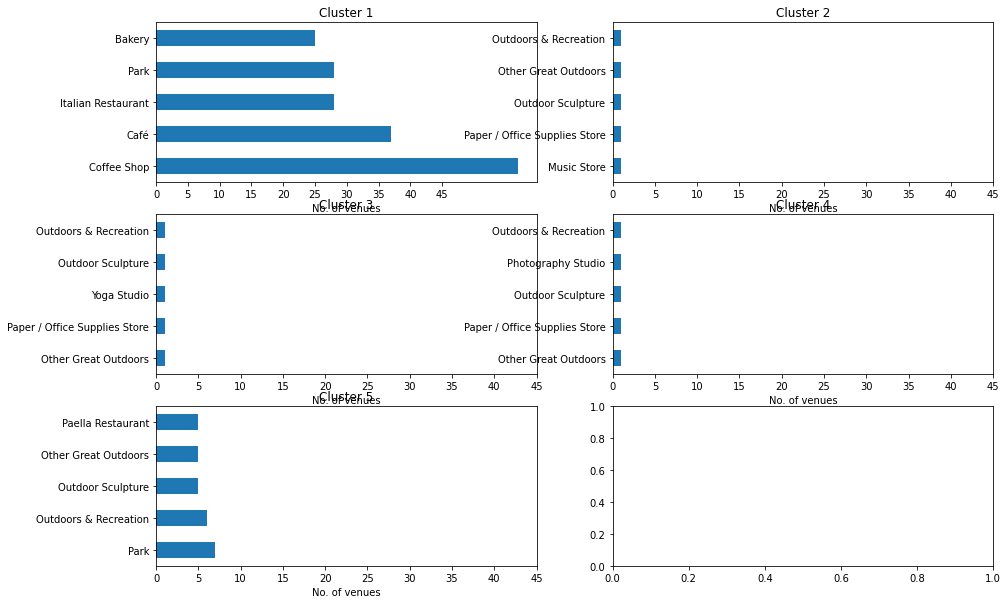

In [102]:
df_list = [venues0 ,venues1, venues2, venues3, venues4] #venues5, venues6, venues7]
fig, axes = plt.subplots(3, 2)

count = 0
for r in range(3):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 50, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

above data using mean / proportion
try to compare total number of venues in each cluster

In [ ]:
# check length
print(len(x1))
print(len(x2))
print(len(y))

79
79
19


In [76]:
#set venues_qty2 as neighborhood,most popular and overall venue qty per neighborhood dataframe


#find neighborhood with 0 venues
venues_qty = city_venues.groupby('Neighborhood').count()
venues_qty = venues_qty.sort_values(by=['Venue'], ascending=False)

x1 =  n_neighborhoods.reset_index()['city'].tolist()
#x1 = x1[0:78]
x2 = venues_qty.reset_index()['Neighborhood'].tolist()
x = [x1,x2]
y= venues_qty.reset_index()['Venue'].tolist()


#create data frame with clusters and number of venues per neighborhood
data = {'City' : x1,
    'Neighborhood' : x2,
  'Venue qty': y}
venues_qty2 = pd.DataFrame(data)
#print(venues_qty2)


#vlookup to get clusters
venues_qty2 = pd.merge(venues_qty2,cities_merged,on='Neighborhood', how='inner')
#venues_qty2 = venues_qty2[:,'City','Neighborhood','Venue qty','Borough','Cluster Labels']
#venues_qty2 = venues_qty2.iloc[:,0:9 ]
venues_qty2.drop('City',inplace=True, axis=1)
#rearrange by clusters ascending
venues_qty2 = venues_qty2.sort_values(by='Cluster Labels', ascending=True)
#change dtype cluster labels to integer
venues_qty2['Cluster Labels'] = venues_qty2['Cluster Labels'].astype(int)
venues_qty2 = venues_qty2.iloc[:,0:9 ]
print(venues_qty2[0:5])



                                         Neighborhood  Venue qty  \
0                                           Yorkville        100   
37                                       Hudson Yards         77   
38                                 Central Bay Street         76   
40          Kensington Market, Chinatown, Grange Park         59   
41  CN Tower, King and Spadina, Railway Lands, Har...         58   

             Borough   Latitude  Longitude       city PostalCode  \
0          Manhattan  40.775930 -73.947118  Manhattan        NaN   
37         Manhattan  40.756658 -74.000111  Manhattan        NaN   
38  Downtown Toronto  43.656400 -79.386000    Toronto        M5G   
40  Downtown Toronto  43.654100 -79.397800    Toronto        M5T   
41  Downtown Toronto  43.640400 -79.399500    Toronto        M5V   

    Cluster Labels 1st Most Common Venue  
0                0    Italian Restaurant  
37               0  Gym / Fitness Center  
38               0           Coffee Shop  
40        

In [77]:
#check how many venues for each neighborhood
#note limitation on Foursquare venues search roughly 23 venues per neighborhood at times
# current limt to 100 venues per neighborhood
#compare manhattan vs toronto
import plotly.graph_objects as go


fig= go.Figure()
fig.update_layout(
    template="simple_white",
    xaxis=dict(title_text="Cluster City Neighborhood"),
    yaxis=dict(title_text="Venue Count"),
    width=1500,
    height = 1500,
    margin = dict(
        l=50,
        r=50,
        b= 400,
        t=100,
        pad=5
    )
)

colors = ["#2A66DE", "#FFC32B"]
x1 =  venues_qty2['Cluster Labels']
x2 = venues_qty2['Neighborhood']
x = [x1,x2]
y= venues_qty2['Venue qty']


fig.add_bar(x=x, y=y)

#fig.add_bar(x=venues_qty[''])
#fig.update_layout(barmode="relative")


fig.show()

optimized K was minimum 3
from graph above, can be seen quite true, main clusters are

* cluster 0 : mainly high venue count, significant number of cafes, coffee shops and restaurants
* cluster 1,2,3 : low venue count, little to no venues listed on foursquare. mainly outdoor focused
* cluster 4 : low number of venues listed. also outdoor focused. however, emphasis on parks and outdoor sculptures, interspersed with stores suggest these neighborhoods are housing areas.

to check other indicators such as population for viability of setting a business

### Mapping

Check map of neighborhood by cluster
* Manhattan
* Toronto

### add a population chloropleth
* get geojson file delineating neighborhoods
    * New york :
        * GeoJSON by NTA : https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page#:~:text=Archived%20Data%20Sets-,Neighborhood%20Tabulation%20Areas%20(Formerly%20%22Neighborhood%20Projection%20Areas%22),plan%20for%20New%20York%20City.
        * population data
        * Race data : https://www1.nyc.gov/assets/planning/download/pdf/data-maps/nyc-population/census2010/t_pl_p3a_nta.pdf
            needed to convert this pdf to table format
    * Toronto : 
        * JSON data : https://nad.carto.com/tables/neighbourhoods_toronto/public/map
        https://github.com/jasonicarter/toronto-geojson

In [ ]:
#get NYC neighborhood JSON
#wget.download("https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Community_Districts/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson")



'query'

take population data by tabulation area

In [94]:
#import pandas as pd
# Matplotlib and associated plotting modules

#Read in the population data
fulldata = pd.read_csv('New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv')
#population_manhattan = fulldata[fulldata.Borough =='Manhattan']
population_manhattan = fulldata
#print(population_manhattan[0:5])
#print(population_manhattan.shape)
#print(population_manhattan['Population'].min())
#print(population_manhattan['Population'].max())

#
#read in the race data
racedata = pd.read_csv('demographics by NTA race.csv')
#manhattan_race = racedata[racedata.Borough =='Manhattan']
manhattan_race = racedata
#print(manhattan_race['Asian'])
print(manhattan_race.dtypes)
#print(manhattan_race.shape)
#print(manhattan_race['Asian'].min())
#print(manhattan_race['Asian'].max())


Borough                                         object
2010\nCensus FIPS County Code                  float64
Code                                            object
Name                                            object
Total\nPopulation                                int64
White                                            int64
Black/ African American                          int64
American Indian and Alaska Native                int64
Asian                                            int64
Native\nHawaiian and Other Pacific Islander      int64
Some Other Race                                  int64
Total                                            int64
Hispanic Origin (of any race)                    int64
dtype: object


In [110]:
manhattan_race

,Borough,2010\nCensus FIPS County Code,Code,Name,Total\nPopulation,White,Black/ African American,American Indian and Alaska Native,Asian,Native\nHawaiian and Other Pacific Islander,Some Other Race,Total,Hispanic Origin (of any race)
0,Bronx,5.0,BX01,Claremont-Bathgate,31078,370,13036,82,108,7,60,221,17194
1,Bronx,5.0,BX03,Eastchester-Edenwald-Baychester,34517,1111,24381,147,232,10,148,509,7979
2,Bronx,5.0,BX05,Bedford Park-Fordham North,54415,3637,9805,145,2727,29,490,623,36959
3,Bronx,5.0,BX06,Belmont,27378,5381,5059,38,620,18,84,249,15929
4,Bronx,5.0,BX07,Bronxdale,35538,5559,10594,102,1404,9,169,430,17271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Staten Island,NaN,SI37,Stapleton-Rosebank,26453,9910,5097,72,2565,12,102,427,8268
191,Staten Island,NaN,SI45,New Dorp-Midland Beach,21896,17136,261,28,1148,2,31,215,3075
192,Staten Island,NaN,SI48,Arden Heights,25238,20328,373,22,1675,4,27,249,2560
193,Staten Island,NaN,SI54,Great Kills,40720,35649,169,26,1233,8,56,331,3248


In [108]:
#overlay choropleth with cluster dots
#Create a layer, shaded by test scores:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters_manhattan = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11)
#list down city and clusters
manhattan_venues = venues_qty2[venues_qty2['city']== 'Manhattan']

#share each district by population

geo = "NYcensusblock.json"
manhattan_population = folium.Choropleth(name="Population",geo_data=geo,
                     fill_color='GnBu', fill_opacity=0.5, line_opacity=0.5,
                     threshold_scale = [0,5000,25000,45000,65000,75000,95000,115000,140000],
                     legend_name = ' Population in Neighborhood',
                     data = population_manhattan,
                     key_on='feature.properties.NTAName',
                     columns = ['NTA Name', 'Population']
                     ) .add_to(map_clusters_manhattan)

#geo2= "NYcensusblock.json"
manhattan_asian = folium.Choropleth(name="Asian-population",geo_data=geo,
                     fill_color='OrRd', fill_opacity=0.5, line_opacity=0.5,
                     legend_name = 'Asian Population in Neighborhood',
                     data = manhattan_race,
                    key_on='feature.properties.NTAName',
                    columns = ['Name', 'Asian']
                     ).add_to(map_clusters_manhattan)

#geo3= "NYcensusblock.json"
manhattan_asian = folium.Choropleth(name="Hispanic-population",geo_data=geo,
                     fill_color='OrRd', fill_opacity=0.5, line_opacity=0.5,
                     legend_name = 'Hispanic Population in Neighborhood',
                     data = manhattan_race,
                    key_on='feature.properties.NTAName',
                    columns = ['Name', 'Hispanic Origin (of any race)']
                     ).add_to(map_clusters_manhattan)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
i=0
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_venues['Latitude'], manhattan_venues['Longitude'], manhattan_venues['Neighborhood'], manhattan_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' \r Cluster ' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_manhattan)
    i = i+1

#geo = "NYcensusblock.json"
#map_clusters_manhattan.choropleth(geo_data=geo,
 #                    fill_opacity=0.1, line_opacity=0.2
  #                   ) 

#add layer controller
folium.LayerControl(collapsed=False).add_to(map_clusters_manhattan)


#uncomment below to show map. This is to control files zie
#map_clusters_manhattan

repeat for Toronto

In [106]:
#import pandas as pd


#Read in the neighborhood profiles
fulldata = pd.read_csv('neighbourhood-profiles-2016-csv-Toronto2.csv')
#population_manhattan = fulldata[fulldata.Borough =='Manhattan']
population_toronto = pd.DataFrame(fulldata[fulldata.Characteristic.isin(['Population, 2016', ' Asian origins', ' Latin; Central and South American origins'])])
population_toronto = population_toronto.drop(['Topic', 'Data Source', 'Characteristic'], axis = 1)
population_toronto = population_toronto.T

#population_toronto.reset_index()
#reorganize header
new_header = population_toronto.iloc[1]

population_toronto = population_toronto[3:]

new_header[2] = 'Population'
new_header[1458] = 'Latin American origins'
new_header[1550] = 'Asian origins'

population_toronto.columns = new_header
#population_toronto.columns['Category']= 'Neighborhood'
population_toronto.reset_index(inplace= True)
population_toronto.iloc[:,1:4] = population_toronto.iloc[:,1:4].astype(str).astype(float) #convert dtype to float


#print(population_toronto[0:5])
print(population_toronto.dtypes)
print(population_toronto.head)

#print(population_toronto.shape)
#print(population_toronto['Population'].min())
#print(population_toronto['Population'].max())

Category
index                      object
Population                float64
Latin American origins    float64
Asian origins             float64
dtype: object
<bound method NDFrame.head of Category                         index  Population  Latin American origins  \
0                      Agincourt North     29113.0                   470.0   
1         Agincourt South-Malvern West     23757.0                   480.0   
2                            Alderwood     12054.0                   315.0   
3                                Annex     30526.0                   765.0   
4                    Banbury-Don Mills     27695.0                   585.0   
..                                 ...         ...                     ...   
135                           Wychwood     14349.0                   645.0   
136                     Yonge-Eglinton     11817.0                   370.0   
137                     Yonge-St.Clair     12528.0                   300.0   
138            York University 

In [107]:
#overlay choropleth with cluster dots
import matplotlib.cm as cm
import matplotlib.colors as colors
#Create a layer, shaded by test scores:

map_clusters_toronto = folium.Map(location=[43.6534817, -79.3839347], zoom_start=11)

toronto_venues = venues_qty2[venues_qty2['city']== 'Toronto']

#share each district by population

#geo = "neighbourhoods_toronto.json" #"toronto_crs84.geojson"
#toronto_population = folium.Choropleth(name="Population",geo_data=geo,
#                     fill_color='GnBu', fill_opacity=0.5, line_opacity=0.5,
#                     ) .add_to(map_clusters_toronto)



geo = "neighbourhoods_toronto.json"
toronto_population = folium.Choropleth(name="Population",geo_data=geo,
                     fill_color='GnBu', fill_opacity=0.5, line_opacity=0.5,
                     legend_name = 'Population in Neighborhood',
                     data = population_toronto,
                     key_on='feature.properties.hood',
                     columns = ['index','Population']
                     ) .add_to(map_clusters_toronto)

#geo2= "neighbourhoods_toronto.json"
toronto_asian = folium.Choropleth(name="Asian-population",geo_data=geo,
                     fill_color='OrRd', fill_opacity=0.5, line_opacity=0.5,
                     legend_name = 'Asian Population in Neighborhood',
                     data = population_toronto,
                     key_on='feature.properties.hood',
                     columns = ['index','Asian origins']
                     ).add_to(map_clusters_toronto)

#geo3= "neighbourhoods_toronto.json"
manhattan_asian = folium.Choropleth(name="Hispanic-population",geo_data=geo,
                     fill_color='OrRd', fill_opacity=0.5, line_opacity=0.5,
                     legend_name = 'Latin Population in Neighborhood except Spanish',
                     data = population_toronto,
                     key_on='feature.properties.hood',
                     columns = ['index','Latin American origins']
                     ).add_to(map_clusters_toronto)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
i=0
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_venues['Latitude'], toronto_venues['Longitude'], toronto_venues['Neighborhood'], toronto_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' \r Cluster ' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters_toronto)
    i = i+1

#geo = "NYcensusblock.json"
#map_clusters_manhattan.choropleth(geo_data=geo,
 #                    fill_opacity=0.1, line_opacity=0.2
  #                   ) 

#add layer controller
folium.LayerControl(collapsed=False).add_to(map_clusters_toronto)

#Output the map to an .html file:
#map_clusters_toronto.save(outfile='populationtoronto.html')

#uncomment below to show map. This is to control files zie
#map_clusters_toronto